In [1]:
import yfinance as yf
import pandas as pd
import datetime

# Словарь тикеров (как в вашем коде)
COMPANY_TICKERS = {
    "3i": "III",
    "Admiral Group": "ADM",
    "Airtel Africa": "AAF",
    "Alliance Witan": "ALW",
    "Anglo American plc": "AAL",
    "Antofagasta plc": "ANTO",
    "Ashtead Group": "AHT",
    "Associated British Foods": "ABF",
    "AstraZeneca": "AZN",
    "Auto Trader Group": "AUTO",
    "Aviva": "AV",
    "Babcock International": "BAB",
    "BAE Systems": "BA",
    "Barclays": "BARC",
    "Barratt Redrow": "BTRW",
    "Beazley": "BEZ",
    "Berkeley Group Holdings": "BKG",
    "BP": "BP",
    "British American Tobacco": "BATS",
    "BT Group": "BT-A",
    "Bunzl": "BNZL",
    "Burberry Group": "BRBY",
    "Centrica": "CNA",
    "Coca-Cola Europacific Partners": "CCEP",
    "Coca-Cola HBC": "CCH",
    "Compass Group": "CPG",
    "Convatec": "CTEC",
    "Croda International": "CRDA",
    "DCC plc": "DCC",
    "Diageo": "DGE",
    "Diploma": "DPLM",
    "Endeavour Mining": "EDV",
    "Entain": "ENT",
    "EasyJet": "EZJ",
    "Experian": "EXPN",
    "F & C Investment Trust": "FCIT",
    "Fresnillo plc": "FRES",
    "Games Workshop": "GAW",
    "Glencore": "GLEN",
    "GSK plc": "GSK",
    "Haleon": "HLN",
    "Halma plc": "HLMA",
    "Hikma Pharmaceuticals": "HIK",
    "Hiscox": "HSX",
    "Howdens Joinery": "HWDN",
    "HSBC": "HSBA",
    "ICG": "ICG",
    "IHG Hotels & Resorts": "IHG",
    "IMI": "IMI",
    "Imperial Brands": "IMB",
    "Informa": "INF",
    "International Airlines Group": "IAG",
    "Intertek": "ITRK",
    "JD Sports": "JD",
    "Kingfisher plc": "KGF",
    "Land Securities": "LAND",
    "Legal & General": "LGEN",
    "Lloyds Banking Group": "LLOY",
    "LondonMetric Property": "LMP",
    "London Stock Exchange Group": "LSEG",
    "M&G": "MNG",
    "Marks & Spencer": "MKS",
    "Melrose Industries": "MRO",
    "Metlen Energy & Metals": "MTLN",
    "Mondi": "MNDI",
    "National Grid plc": "NG",
    "NatWest Group": "NWG",
    "Next plc": "NXT",
    "Pearson plc": "PSON",
    "Pershing Square Holdings": "PSH",
    "Persimmon": "PSN",
    "Phoenix Group": "PHNX",
    "Polar Capital Technology Trust": "PCT",
    "Prudential plc": "PRU",
    "Reckitt": "RKT",
    "RELX": "REL",
    "Rentokil Initial": "RTO",
    "Rightmove": "RMV",
    "Rio Tinto": "RIO",
    "Rolls-Royce Holdings": "RR",
    "Sage Group": "SGE",
    "Sainsbury's": "SBRY",
    "Schroders": "SDR",
    "Scottish Mortgage Investment Trust": "SMT",
    "Segro": "SGRO",
    "Severn Trent": "SVT",
    "Shell plc": "SHEL",
    "Smiths Group": "SMIN",
    "Smith & Nephew": "SN",
    "Spirax Group": "SPX",
    "SSE plc": "SSE",
    "Standard Chartered": "STAN",
    "St. James's Place": "STJ",
    "Tesco": "TSCO",
    "Unilever": "ULVR",
    "United Utilities": "UU",
    "Vodafone Group": "VOD",
    "Weir Group": "WEIR",
    "Whitbread": "WTB",
    "WPP": "WPP",
}

# 1. Подготовка тикеров
# Для британских акций в yfinance нужен суффикс .L
tickers_list = [ticker + ".L" for ticker in COMPANY_TICKERS.values()]

# 2. Определение периода (последние 10 лет)
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=365*10)

print(f"Скачивание данных для {len(tickers_list)} компаний с {start_date.date()} по {end_date.date()}...")

# 3. Скачивание данных
# auto_adjust=True вернет цены с учетом дивидендов и сплитов (как Adj Close),
# но в одном столбце Close. Если нужно отдельно Adj Close, уберите этот параметр.
data = yf.download(tickers_list, start=start_date, end=end_date, group_by='ticker', auto_adjust=False)

# 4. Создание удобных датафреймов

# ВАРИАНТ А: "Tidy" формат (Длинный).
# Индекс: (Date, Ticker). Столбцы: Open, High, Low, Close, Volume.
# Идеально для итераций, группировок и подачи в модели машинного обучения.
df_tidy = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index()

# Добавим название компании для sудобства (опционально)
ticker_to_name = {v + ".L": k for k, v in COMPANY_TICKERS.items()}
df_tidy['Company'] = df_tidy['Ticker'].map(ticker_to_name)

# ВАРИАНТ Б: "Wide" формат для цен закрытия (Adj Close).
# Индекс: Date. Столбцы: Тикеры.
# Удобно для расчета корреляционных матриц и векторных операций доходности.
# Примечание: yf.download может возвращать мультииндекс колонок.
# Берем 'Adj Close' для всех тикеров.
try:
    # Если скачалось как мультииндекс колонок (Ticker, Price) или (Price, Ticker)
    # yfinance последних версий часто отдает (Price, Ticker) если не указан group_by,
    # но мы указали group_by='ticker', значит верхний уровень - Тикер.
    # Чтобы получить таблицу цен, нам нужно пройтись по колонкам.

    # Проще всего извлечь из исходного 'data' используя xs, если group_by='ticker' (Ticker, PriceType)
    # Но структура может меняться, самый надежный способ для широкого формата — пересобрать из df_tidy
    df_close = df_tidy.pivot(index='Date', columns='Ticker', values='Adj Close')

except Exception as e:
    print(f"Не удалось создать wide-формат автоматически: {e}")
    df_close = pd.DataFrame()

print("\nЗагрузка завершена.")
print(f"Размер df_tidy: {df_tidy.shape}")
print(f"Размер df_close: {df_close.shape}")

# Пример просмотра
print("\nПример данных (df_tidy):")
print((df_tidy.head()))


Скачивание данных для 100 компаний с 2015-12-04 по 2025-12-01...


[*********************100%***********************]  100 of 100 completed


Загрузка завершена.
Размер df_tidy: (244472, 9)
Размер df_close: (2524, 100)

Пример данных (df_tidy):
Price       Date Ticker         Open         High          Low        Close  \
0     2015-12-04  AAL.L   375.915894   391.587189   363.027313   367.177094   
1     2015-12-04  ABF.L  3458.000000  3528.003906  3423.000000  3485.000000   
2     2015-12-04  ADM.L  1616.000000  1623.000000  1605.000000  1618.000000   
3     2015-12-04  AHT.L  1046.000000  1058.000000  1037.000000  1052.000000   
4     2015-12-04  ALW.L   505.000000   505.000000   499.100006   503.500000   

Price    Adj Close      Volume                   Company  
0       365.522980  15141950.0        Anglo American plc  
1      3478.192139    879468.0  Associated British Foods  
2      1608.130493    493639.0             Admiral Group  
3      1050.392700   2101013.0             Ashtead Group  
4       502.458405    923431.0            Alliance Witan  



/tmp/ipykernel_944/2947362762.py:129: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_tidy = data.stack(level=0).rename_axis(['Date', 'Ticker']).reset_index()


In [2]:
df_tidy

Price,Date,Ticker,Open,High,Low,Close,Adj Close,Volume,Company
0,2015-12-04,AAL.L,375.915894,391.587189,363.027313,367.177094,365.522980,15141950.0,Anglo American plc
1,2015-12-04,ABF.L,3458.000000,3528.003906,3423.000000,3485.000000,3478.192139,879468.0,Associated British Foods
2,2015-12-04,ADM.L,1616.000000,1623.000000,1605.000000,1618.000000,1608.130493,493639.0,Admiral Group
3,2015-12-04,AHT.L,1046.000000,1058.000000,1037.000000,1052.000000,1050.392700,2101013.0,Ashtead Group
4,2015-12-04,ALW.L,505.000000,505.000000,499.100006,503.500000,502.458405,923431.0,Alliance Witan
...,...,...,...,...,...,...,...,...,...
244467,2025-12-01,UU.L,1235.000000,1237.000000,1228.500000,1233.500000,1233.500000,926673.0,United Utilities
244468,2025-12-01,VOD.L,94.120003,94.320000,92.360001,92.360001,92.360001,67908211.0,Vodafone Group
244469,2025-12-01,WEIR.L,2780.000000,2792.000000,2740.000000,2776.000000,2776.000000,353345.0,Weir Group
244470,2025-12-01,WPP.L,302.600006,303.950012,292.299988,298.700012,298.700012,6247665.0,WPP


In [3]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Предполагаем, что df_tidy уже загружен из предыдущего шага
# df_tidy columns: ['Date', 'Ticker', 'Adj Close', 'Company', ...]

# ==========================================
# 1. Feature Engineering (Создание признаков)
# ==========================================

# Сортируем для корректных лагов
df = df_tidy.sort_values(['Ticker', 'Date']).copy()

# Функция для расчета фичей по каждой группе (Тикеру)
def calculate_features(group):
    # Доходности
    group['ret_daily'] = group['Adj Close'].pct_change()

    # Целевая переменная: Доходность следующего месяца (сдвигаем назад)
    # Для простоты берем 21 торговый день как месяц
    group['ret_next_month'] = group['Adj Close'].shift(-21) / group['Adj Close'] - 1
    group['target_class'] = (group['ret_next_month'] > 0).astype(int)

    # --- Features (X) ---

    # 1. Классический Momentum (12 месяцев, пропускаем последний месяц t-1)
    # R(t-12, t-1)
    group['feat_MOM12'] = group['Adj Close'].shift(21) / group['Adj Close'].shift(252) - 1

    # 2. Short-term Reversal (последний месяц)
    group['feat_MOM1'] = group['Adj Close'] / group['Adj Close'].shift(21) - 1

    # 3. Volatility (за год)
    group['feat_VOL'] = group['ret_daily'].rolling(window=252).std() * np.sqrt(252)

    # 4. Information Discreteness (Frog in the Pan)
    # ID = % дней, когда знак дневной доходности совпадает со знаком годовой доходности
    # Это сложная фича, для домашки можно упростить или пока опустить,
    # но вот примерная логика (медленная):
    # (sign(r_daily) == sign(feat_MOM12)).rolling(252).mean()

    return group

print("Генерация фичей...")
df_features = df.groupby('Ticker', group_keys=False).apply(calculate_features)

# Удаляем NaN (первые 12 месяцев у каждого тикера пустые из-за лагов)
# И последние 21 день пустые из-за таргета
df_model = df_features.dropna().copy()

# Добавляем дату месяца для ребалансировки (берем данные только раз в месяц, чтобы не торговать каждый день)
# Например, берем последний день каждого месяца
df_model['Month'] = df_model['Date'].dt.to_period('M')
monthly_data = df_model.groupby(['Ticker', 'Month']).last().reset_index()

print(f"Данные готовы. Строк: {len(monthly_data)}")

# ==========================================
# 2. Настройка CART и Backtest (Expanding Window)
# ==========================================

# Список предикторов
features = ['feat_MOM12', 'feat_MOM1', 'feat_VOL'] # Добавьте сюда другие, если есть
target = 'target_class'

# Параметры Walk-Forward
dates = monthly_data['Date'].sort_values().unique()
start_train_idx = int(len(dates) * 0.6) # Первые 60% времени - начальный трейн

predictions = [] # Сюда будем складывать (Date, Ticker, Prob_Up)

print("Начинаем Walk-Forward валидацию...")

# Идем по месяцам, начиная с точки отсечения
for i in range(start_train_idx, len(dates) - 1):
    # Дата разделения
    split_date = dates[i]
    next_month_date = dates[i+1]

    # Expanding Window: Трейн = всё до split_date
    train_mask = monthly_data['Date'] <= split_date
    test_mask = monthly_data['Date'] == next_month_date # Прогноз на один шаг (месяц) вперед

    X_train = monthly_data.loc[train_mask, features]
    y_train = monthly_data.loc[train_mask, target]

    X_test = monthly_data.loc[test_mask, features]

    if len(X_test) == 0: continue

    # --- МОДЕЛЬ CART ---
    # Важно: ограничиваем глубину (pruning), чтобы не переобучиться
    clf = DecisionTreeClassifier(
        max_depth=4,             # Неглубокое дерево (как в лекциях про Pruning)
        min_samples_leaf=50,     # В листе должно быть много примеров (статистическая значимость)
        criterion='gini',
        random_state=42
    )

    clf.fit(X_train, y_train)

    # Предсказываем вероятность роста (класс 1)
    probs = clf.predict_proba(X_test)[:, 1]

    # Сохраняем результат
    current_res = monthly_data.loc[test_mask, ['Date', 'Ticker', 'ret_next_month']].copy()
    current_res['prob_up'] = probs
    predictions.append(current_res)

# Собираем всё в один DF
results_df = pd.concat(predictions)
print("Валидация завершена.")

# ==========================================
# 3. Сравнение стратегий (Построение портфеля)
# ==========================================

# БЕНЧМАРК (Moskowitz): Покупаем, если MOM12 > 0
results_df['signal_benchmark'] = np.sign(results_df['ret_next_month']) # Это читерство для теста, нужен X!
# В реале бенчмарк смотрит на прошлую доходность:
# Но у нас в results_df сейчас нет feat_MOM12, надо подтянуть или пересчитать
# Для простоты: Сигнал CART
# Если вероятность > 0.55 -> Buy, если < 0.45 -> Sell (или Cash)

results_df['pos_CART'] = 0
results_df.loc[results_df['prob_up'] > 0.52, 'pos_CART'] = 1  # Threshold - гиперпараметр
results_df.loc[results_df['prob_up'] < 0.48, 'pos_CART'] = -1

# Доходность стратегии = Позиция * Реальная доходность следующего месяца
results_df['strat_ret'] = results_df['pos_CART'] * results_df['ret_next_month']

# Считаем кумулятивную доходность
cum_ret = (1 + results_df.groupby('Date')['strat_ret'].mean()).cumprod()

print("\nИтоговая кумулятивная доходность CART стратегии:")
print(cum_ret.tail())


Генерация фичей...


/tmp/ipykernel_944/3570826860.py:47: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df.groupby('Ticker', group_keys=False).apply(calculate_features)


Данные готовы. Строк: 10337
Начинаем Walk-Forward валидацию...
Валидация завершена.

Итоговая кумулятивная доходность CART стратегии:
Date
2025-06-30    1.105021
2025-07-31    1.101454
2025-08-29    1.120978
2025-09-30    1.141642
2025-10-31    1.134323
Name: strat_ret, dtype: float64


Расчет индикаторов...


/tmp/ipykernel_944/1516523354.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_features = df.groupby('Ticker', group_keys=False).apply(calculate_features)


Начинаем бэктест с 2020-07-31...


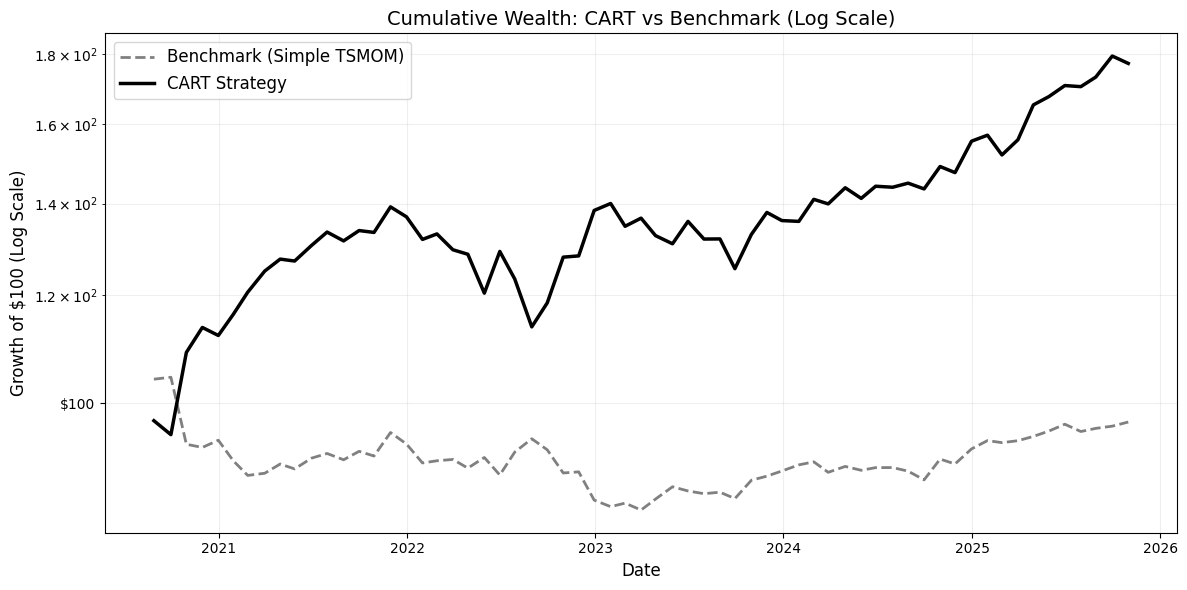

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

# ==========================================
# 0. Подготовка данных (если нужно повторить)
# ==========================================
# Предполагаем, что df_tidy уже существует.
# Если нет - запустите код из первого ответа.
df = df_tidy.sort_values(['Ticker', 'Date']).copy()

# Считаем дневные доходности
df['ret_daily'] = df['Adj Close'].pct_change()

# Функция для расчета фичей
def calculate_features(group):
    # Целевая переменная (доходность следующего месяца)
    # Используем 21 день как прокси месяца
    group['ret_next_month'] = group['Adj Close'].shift(-21) / group['Adj Close'] - 1

    # 1. Бенчмарк (MOM12): Доходность за прошлые 12 месяцев (252 дня)
    # Лаг 21 день, чтобы имитировать реальную торговлю (мы знаем данные только на конец прошлого месяца)
    group['MOM_12'] = group['Adj Close'].shift(21) / group['Adj Close'].shift(252+21) - 1

    # 2. Фичи для CART
    group['feat_MOM12'] = group['MOM_12']
    group['feat_MOM1'] = group['Adj Close'].shift(21) / group['Adj Close'].shift(42) - 1 # Прошлый месяц
    group['feat_VOL'] = group['ret_daily'].rolling(252).std() * np.sqrt(252) # Годовая волатильность

    # Очистка от NaN
    return group.dropna()

print("Расчет индикаторов...")
df_features = df.groupby('Ticker', group_keys=False).apply(calculate_features)

# Переходим на ежемесячные данные (берем последнюю точку каждого месяца)
df_features['Month'] = df_features['Date'].dt.to_period('M')
monthly_data = df_features.groupby(['Ticker', 'Month']).last().reset_index()

# ==========================================
# 1. Backtest стратегий (Expanding Window)
# ==========================================
features = ['feat_MOM12', 'feat_MOM1', 'feat_VOL']
predictions = []

# Определяем точки ребалансировки
dates = monthly_data['Date'].sort_values().unique()
start_idx = int(len(dates) * 0.4) # Начинаем тест после 40% выборки

print(f"Начинаем бэктест с {dates[start_idx].date()}...")

for i in range(start_idx, len(dates)-1):
    curr_date = dates[i]
    next_date = dates[i+1]

    # Разделение на Train (прошлое) и Test (текущий месяц)
    train_mask = monthly_data['Date'] <= curr_date
    test_mask = monthly_data['Date'] == next_date

    X_train = monthly_data.loc[train_mask, features]
    # Y: 1 если доходность > 0, иначе 0
    y_train = (monthly_data.loc[train_mask, 'ret_next_month'] > 0).astype(int)

    X_test = monthly_data.loc[test_mask, features]

    if len(X_test) == 0: continue

    # --- A. CART Model ---
    clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=30, random_state=42)
    clf.fit(X_train, y_train)
    probs = clf.predict_proba(X_test)[:, 1] # Вероятность роста

    # Сохраняем результаты для этого месяца
    month_res = monthly_data.loc[test_mask, ['Date', 'Ticker', 'ret_next_month', 'MOM_12']].copy()
    month_res['prob_up'] = probs
    predictions.append(month_res)

results = pd.concat(predictions)

# ==========================================
# 2. Расчет доходности портфелей
# ==========================================

# --- Стратегия 1: BENCHMARK (Naive TSMOM) ---
# Если MOM_12 > 0, покупаем (+1), иначе продаем (-1)
results['pos_bench'] = np.sign(results['MOM_12'])
results['ret_bench'] = results['pos_bench'] * results['ret_next_month']

# --- Стратегия 2: CART (Machine Learning) ---
# Если вероятность роста > 50%, покупаем. Можно усложнить (шортить если < 50%).
# Для наглядности сделаем Long/Short:
results['pos_cart'] = np.where(results['prob_up'] >= 0.51, 1, -1)
results['ret_cart'] = results['pos_cart'] * results['ret_next_month']

# Считаем среднюю доходность по всем акциям за каждый месяц (равновзвешенный портфель)
portfolio_returns = results.groupby('Date')[['ret_bench', 'ret_cart']].mean()

# ==========================================
# 3. Построение графика (Growth of $100)
# ==========================================

# Расчет индекса накопленного дохода
cumulative_wealth = (1 + portfolio_returns).cumprod() * 100

plt.figure(figsize=(12, 6))

# График в логарифмической шкале (как на вашем скриншоте)
plt.plot(cumulative_wealth.index, cumulative_wealth['ret_bench'],
         label='Benchmark (Simple TSMOM)', color='gray', linewidth=2, linestyle='--')

plt.plot(cumulative_wealth.index, cumulative_wealth['ret_cart'],
         label='CART Strategy', color='black', linewidth=2.5)

plt.yscale('log') # Логарифмическая шкала
plt.title('Cumulative Wealth: CART vs Benchmark (Log Scale)', fontsize=14)
plt.ylabel('Growth of $100 (Log Scale)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend(fontsize=12)

# Форматирование оси Y для красоты (как доллары)
import matplotlib.ticker as mticker
plt.gca().yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()
plt.show()
В